Dataset 'house_price.csv' loaded successfully.

--- 1. Initial Data Inspection and Exploration ---

First 5 rows of the dataset:
   size   location  no.of rooms     price mainroad  no.of vehicles in parking  \
0  1200     Mumbai            3  15000000      yes                          2   
1   850      Delhi            2   7500000      yes                          1   
2  1500  Bangalore            4  20000000      yes                          3   
3   700    Chennai            2   6000000       no                          1   
4  1000  Hyderabad            3   9000000      yes                          2   

  furnishing status  
0         furnished  
1    semi-furnished  
2         furnished  
3       unfurnished  
4    semi-furnished  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   size              

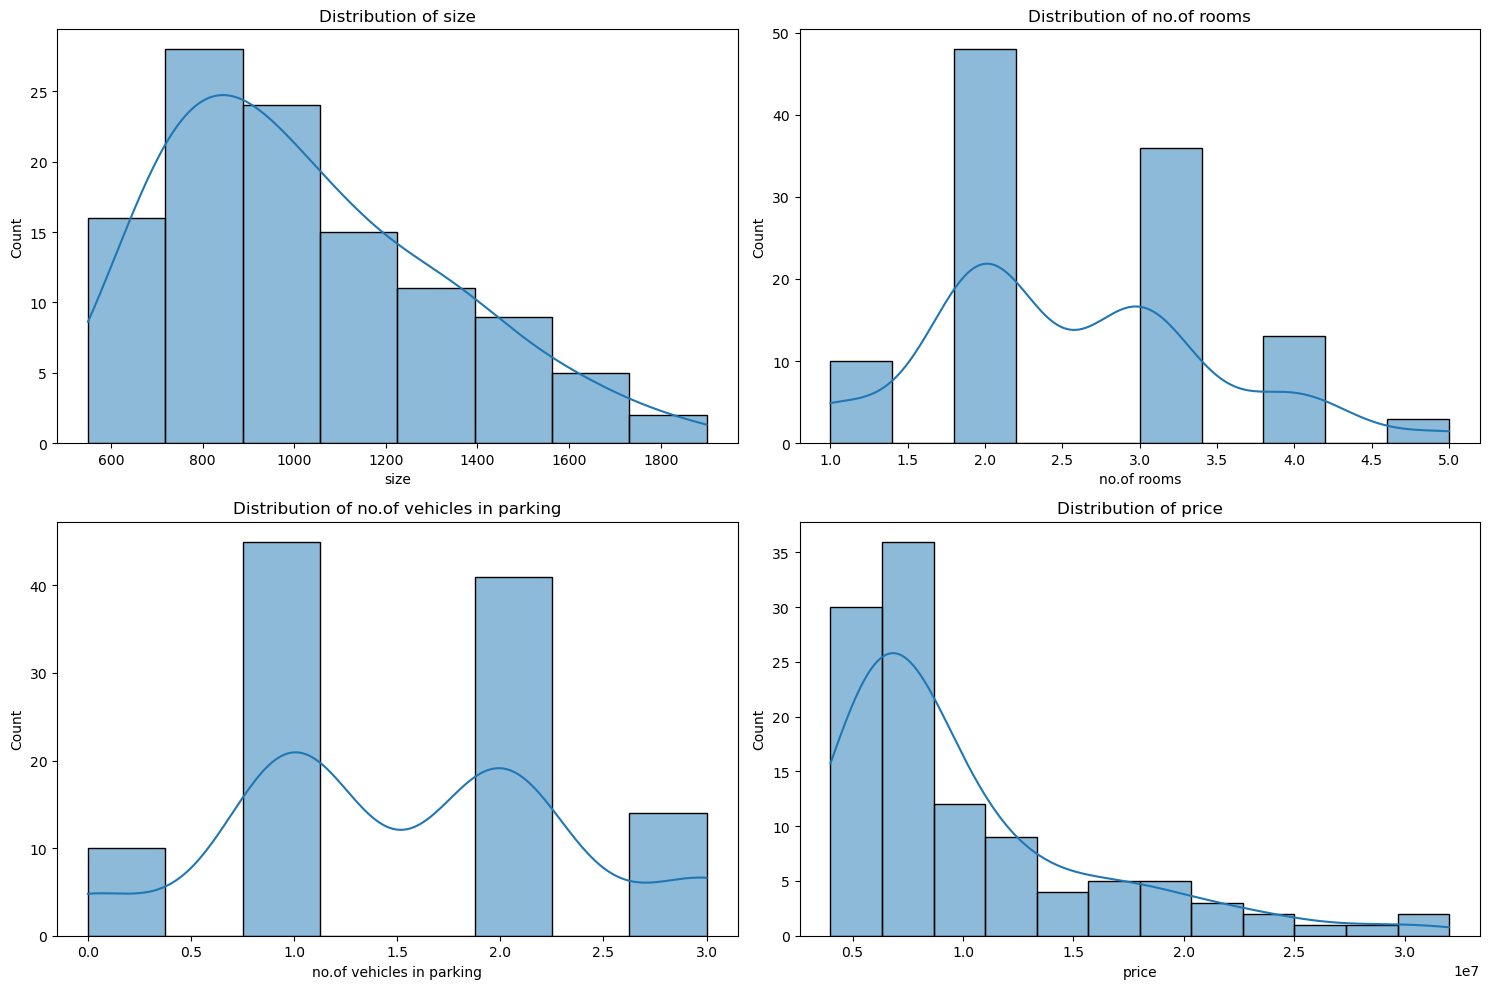

Histograms displayed for numerical feature distributions.

--- Identifying and Handling Potential Outliers (using IQR method) ---


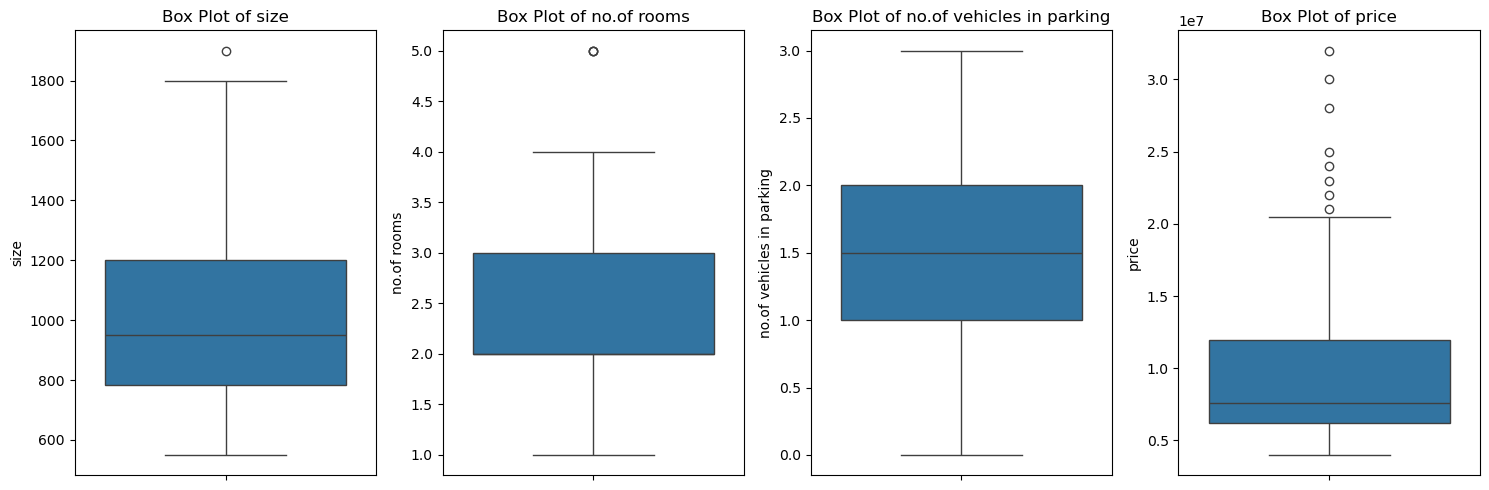

Box plots displayed for visual outlier identification.
  1 outliers detected in 'size'. Capping them.
  3 outliers detected in 'no.of rooms'. Capping them.
  No significant outliers detected in 'no.of vehicles in parking' to cap.
  8 outliers detected in 'price'. Capping them.
Outlier handling (capping using IQR) complete for numerical features.

--- 2. Data Preprocessing ---
Numerical data normalized and categorical data encoded.

--- 3. Feature Selection ---

Correlation Analysis of Numerical Features with Price:
price                        1.000000
size                         0.927023
no.of rooms                  0.871894
no.of vehicles in parking    0.820662
Name: price, dtype: float64


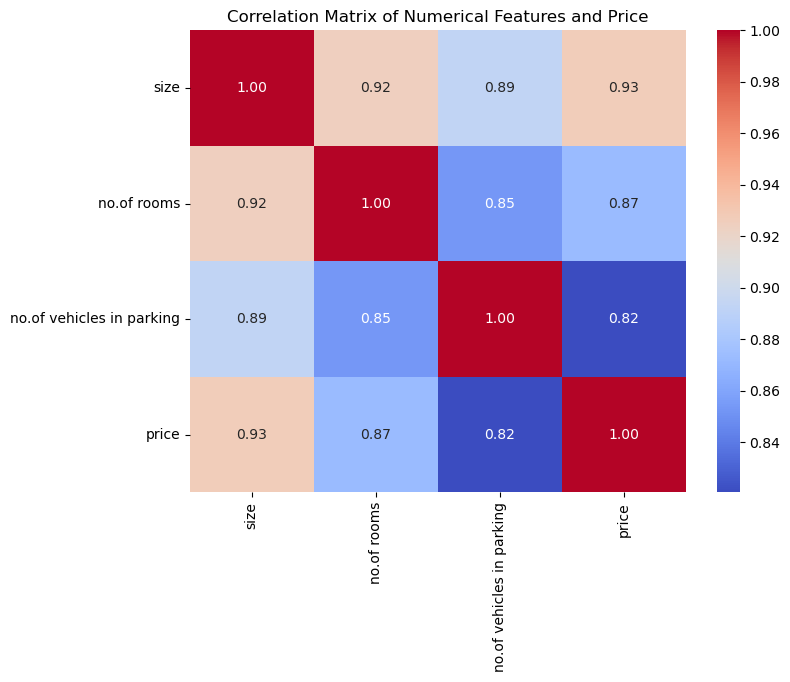

Correlation heatmap displayed for numerical features vs. Price.

Absolute Correlation of all Preprocessed Features with Price (Sorted):
size                                0.927023
no.of rooms                         0.871894
no.of vehicles in parking           0.820662
location_Mumbai                     0.598205
location_Bangalore                  0.516436
furnishing status_furnished         0.364692
furnishing status_unfurnished      -0.348354
location_Ahmedabad                 -0.336606
mainroad_no                        -0.287532
mainroad_yes                        0.287532
location_Lucknow                   -0.268977
location_Chennai                   -0.209341
location_Delhi                     -0.186593
location_Kolkata                    0.177986
location_Jaipur                    -0.174297
location_Pune                      -0.168149
location_Hyderabad                  0.051336
furnishing status_semi-furnished   -0.044238
Name: price, dtype: float64

Potential low-impact pred

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# 1. Dataset Selection
# Dataset Name: house_prices.csv
try:
    df = pd.read_csv('house_price.csv')
    print("Dataset 'house_price.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'house_price.csv' not found. Please make sure the CSV file is in the same directory as the script.")
    exit()

# Make a copy for preprocessing steps to keep the original DataFrame intact
df_processed = df.copy()
print("\n--- 1. Initial Data Inspection and Exploration ---")

# Inspect the Dataset:
print("\nFirst 5 rows of the dataset:")
print(df_processed.head())
print("\nDataset Info:")
df_processed.info()

# Check for missing values and handle them appropriately.
print("\nMissing values before handling:")
print(df_processed.isnull().sum())

# Handling Missing Values: Impute numerical with median, categorical with mode
numerical_cols_for_imputation = df_processed.select_dtypes(include=np.number).columns.tolist()
# Exclude 'price' from imputation if it's strictly a target, but it's good practice to handle it if it could be missing
if 'price' in numerical_cols_for_imputation:
    numerical_cols_for_imputation.remove('price') # Price should ideally not have missing target values.

for col in numerical_cols_for_imputation:
    if df_processed[col].isnull().any():
        print(f"Imputing missing values in numerical column '{col}' with its median.")
        median_value = df_processed[col].median()
        df_processed[col].fillna(median_value, inplace=True)

categorical_cols_for_imputation = df_processed.select_dtypes(include='object').columns.tolist()
for col in categorical_cols_for_imputation:
    if df_processed[col].isnull().any():
        print(f"Imputing missing values in categorical column '{col}' with its mode.")
        mode_value = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_value, inplace=True)

print("\nMissing values after handling:")
print(df_processed.isnull().sum())


# Analyze distributions of numerical variables (e.g., Size, Price).
print("\n--- Analyzing Distributions of Numerical Variables ---")
numerical_features_for_dist = ['size', 'no.of rooms', 'no.of vehicles in parking', 'price']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features_for_dist):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_processed[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()
print("Histograms displayed for numerical feature distributions.")

# Identify potential outliers that might skew results.
print("\n--- Identifying and Handling Potential Outliers (using IQR method) ---")
# Box plots for visual outlier identification
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_features_for_dist):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=df_processed[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()
print("Box plots displayed for visual outlier identification.")

# Function to detect and cap outliers using IQR method
def cap_outliers_iqr(dataframe, col):
    Q1 = dataframe[col].quantile(0.25)
    Q3 = dataframe[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)].shape[0]
    if outliers_count > 0:
        print(f"  {outliers_count} outliers detected in '{col}'. Capping them.")
        dataframe[col] = np.where(dataframe[col] < lower_bound, lower_bound, dataframe[col])
        dataframe[col] = np.where(dataframe[col] > upper_bound, upper_bound, dataframe[col])
    else:
        print(f"  No significant outliers detected in '{col}' to cap.")
    return dataframe

# Apply outlier handling to each numerical column
for col in numerical_features_for_dist:
    df_processed = cap_outliers_iqr(df_processed, col)
print("Outlier handling (capping using IQR) complete for numerical features.")


# 2. Data Preprocessing
print("\n--- 2. Data Preprocessing ---")

# Define numerical and categorical features for transformation
numerical_features = ['size', 'no.of rooms', 'no.of vehicles in parking'] # Exclude 'price' from features
categorical_features = ['location', 'mainroad', 'furnishing status']

# Normalize Numerical Data:
# Scale features like Size and Number of Rooms to bring them to a comparable range using methods like Min-Max Scaling or Standardization.
# Encode Categorical Features:
# Convert Location into numerical values using One-Hot Encoding for non-ordinal categories.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Separate features (X) and target (y)
X = df_processed.drop('price', axis=1) # Use df_processed after all previous steps
y = df_processed['price']

# Apply preprocessing to X
X_preprocessed = preprocessor.fit_transform(X)

# Get feature names after one-hot encoding for better interpretability
# This step is crucial for understanding feature importance later
feature_names = numerical_features + \
                list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)
print("Numerical data normalized and categorical data encoded.")


# 3. Feature Selection
print("\n--- 3. Feature Selection ---")
# Analyze Predictors:
# Use correlation analysis to identify relationships between features and the target variable (Price).
print("\nCorrelation Analysis of Numerical Features with Price:")
correlation_matrix = df_processed[numerical_features + ['price']].corr()
print(correlation_matrix['price'].sort_values(ascending=False))

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Price')
plt.show()
print("Correlation heatmap displayed for numerical features vs. Price.")
temp_df_for_correlation = X_preprocessed_df.copy()
temp_df_for_correlation['price'] = y.values # Add price to this temp df

# Calculate correlations with the target variable 'price'
feature_correlations = temp_df_for_correlation.corr()['price'].sort_values(key=abs, ascending=False)
feature_correlations = feature_correlations.drop('price') # Remove self-correlation

print("\nAbsolute Correlation of all Preprocessed Features with Price (Sorted):")
print(feature_correlations)

# Consider removing low-impact predictors to improve model performance.
# Threshold for low-impact (this is an example, adjust based on your data and domain knowledge)
LOW_IMPACT_THRESHOLD = 0.05 # Example threshold for absolute correlation
low_impact_predictors = feature_correlations[abs(feature_correlations) < LOW_IMPACT_THRESHOLD].index.tolist()

if low_impact_predictors:
    print(f"\nPotential low-impact predictors (absolute correlation < {LOW_IMPACT_THRESHOLD}):")
    print(low_impact_predictors)
    print("These features *could* be considered for removal to potentially improve model performance or simplify the model.")
else:
    print(f"\nNo features found with absolute correlation less than {LOW_IMPACT_THRESHOLD}. No predictors to remove based on this threshold.")


# 4. Model Training
print("\n--- 4. Model Training ---")

# Train-Test Split:
# Divide the dataset into training and testing sets (e.g., 80% train, 20% test).
# Ensure the split is random but reproducible.
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.2, random_state=42)
print(f"Dataset split into training (80%) and testing (20%) sets.")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Train a Linear Regression Model:
model = LinearRegression()
model.fit(X_train, y_train)
print("Linear Regression model trained successfully.")


# 5. Model Evaluation
print("\n--- 5. Model Evaluation ---")

# Predictions:
# Outputs for the test data including predicted vs. actual prices.
y_pred = model.predict(X_test)

print("Sample of Actual vs. Predicted Prices (Test Data):")
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions_df.head())

# Evaluation Metrics:
# Calculate Root Mean Square Error (RMSE) to measure prediction accuracy.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# Determine R^2 (Coefficient of Determination) to evaluate how well the model explains variability in the data.
r2 = r2_score(y_test, y_pred)

print(f"\nRoot Mean Square Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print("\n--- Feature Insights ---")
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
coefficients['Absolute_Coefficient'] = np.abs(coefficients['Coefficient'])
coefficients = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)
print("Top 10 Most Important Predictors (by absolute coefficient magnitude):")
print(coefficients.head(10))
print("These coefficients indicate the impact of each feature on house prices (higher absolute value means more impact).")
